In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Defining the input and output data

In [3]:
# Number of examples
m = 401

# Generate 401 equally spaced points between -1 and 1
points = np.linspace(-1, 1, m).reshape(m, 1, 1)

# Create the array where the first slice is the points and the second slice is 0.01
input_array = np.concatenate((points, np.full((m, 1, 1), 0.01)), axis=2)

# Generate 401 equally spaced points between -1 and 1
points1 = np.linspace(-1, 1, m).astype(np.float32)
input_points = torch.from_numpy(points1).type(torch.float32)

# Convert numpy array to torch tensor with dtype=torch.float32
input_tensor = torch.from_numpy(input_array).type(torch.float32)
# Calculate targets using the sine function with dtype=torch.float32
output_tensor = torch.sin(torch.pi * input_points).reshape(len(input_points), 1).type(torch.float32)
print(input_tensor.shape, output_tensor.shape)

torch.Size([401, 1, 2]) torch.Size([401, 1])


Interval operations used in this INN

In [5]:
def multiply_CRmatrix_to_scalar_matrix(A, B):
    """
    Multiply CR-type interval matrix to scalar matrix using interval operations.

    Args:
    A: torch tensor, shape (m, n, 2), CR interval matrix A
    B: torch tensor, shape (n, p), scalar matrix B

    Returns:
    C: torch tensor, shape (m, p, 2), CR interval matrix resulting from A*B where * is scalar multiplication defined above.
    """
    m, n, _ = A.shape
    n_B, p = B.shape
    assert n == n_B, "Inner dimensions must match for matrix multiplication."

    # Extract center and radius from A
    A_C = A[..., 0]  # Center matrix, shape (m, n)
    A_R = A[..., 1]  # Radius matrix, shape (m, n)
    
    # Compute the center of the resulting matrix
    C_C = torch.matmul(A_C, B)  # Shape (m, p)

    # Compute the radius of the resulting matrix
    abs_B = torch.abs(B)
    C_R = torch.matmul(A_R, abs_B)  # Shape (m, p)

    # Combine the center and radius into the resulting CR matrix
    C = torch.stack((C_C, C_R), dim=-1)
    return C


In [6]:
def apply_function_to_CR_interval(a, f):
    """
    Apply function f to a CR interval matrix a.

    Args:
    a: torch tensor, shape (m, n, 2), CR interval matrix a
    f: function to be applied element-wise

    Returns:
    result: torch tensor, shape (m, n, 2), CR interval matrix after applying f
    """
    # Extract center and radius
    a_C = a[..., 0]
    a_R = a[..., 1]

    # Apply function f to the intervals
    f_plus = f(a_C + a_R)
    f_minus = f(a_C - a_R)

    # Calculate new center and radius
    new_C = (f_plus + f_minus) / 2
    new_R = (f_plus - f_minus) / 2

    # Combine the new center and radius into the resulting CR interval matrix
    result = torch.stack((new_C, new_R), dim=-1)
    return result

In [7]:
def add_bias_to_CR_interval(XW, b):
    """
    Add bias vector b to the center of the CR interval matrix XW.

    Args:
    XW: torch tensor, shape (m, n, 2), CR interval matrix
    b: torch tensor, shape (1, n), bias vector

    Returns:
    result: torch tensor, shape (m, n, 2), CR interval matrix after adding bias
    """
    # Extract center and radius
    XW_C = XW[..., 0]  # Center part, shape (m, n)
    XW_R = XW[..., 1]  # Radius part, shape (m, n)

    # Add bias to the center part
    result_C = XW_C + b

    # Combine the new center and original radius into the resulting CR interval matrix
    result = torch.stack((result_C, XW_R), dim=-1)
    return result

Splitting data into training and testing sets

In [9]:

# Splitting data into training and testing sets
train_input_tensor, test_input_tensor, train_output_tensor, test_output_tensor = train_test_split(
    input_tensor, output_tensor, test_size=0.2, random_state=42
)
print(train_input_tensor.shape, test_input_tensor.shape, train_output_tensor.shape, test_output_tensor.shape)


torch.Size([320, 1, 2]) torch.Size([81, 1, 2]) torch.Size([320, 1]) torch.Size([81, 1])


In [10]:
# Define batch size
batch_size = 64

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(train_input_tensor, train_output_tensor)
test_dataset = TensorDataset(test_input_tensor, test_output_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

torch.manual_seed(2)

The Inteval Neural Network

In [12]:
class CustomLinear(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomLinear, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_size, output_size))
        self.bias = nn.Parameter(torch.Tensor(1, output_size))
        self.reset_parameters()
        
    def reset_parameters(self):
        # Using Xavier initialization for weights
        nn.init.xavier_normal_(self.weight)
        
        # Initialize biases to zero
        nn.init.xavier_normal_(self.bias)
    def forward(self, x):
        weighted_input = multiply_CRmatrix_to_scalar_matrix(x, self.weight)
        output =  add_bias_to_CR_interval(weighted_input, self.bias)
        return output
        
# Define the neural network model with custom linear layers
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super(CustomNeuralNetwork, self).__init__()
        self.layer1 = CustomLinear(input_tensor.shape[1], 16)
        self.activation = apply_function_to_CR_interval
        self.layer2 = CustomLinear(16, 16)
        self.activation = apply_function_to_CR_interval
        #self.layer3 = CustomLinear(16, 16)
        #self.activation = apply_function_to_CR_interval
        self.layer3 = CustomLinear(16, output_tensor.shape[1])

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x, nn.Tanh())
        x = self.layer2(x)
        x = self.activation(x, nn.Tanh())
        #x = self.layer3(x)
        #x = self.activation(x, torch.relu)
        x = self.layer3(x)
        return x

class IntervalMSELoss(nn.Module):
    def __init__(self, beta):
        super(IntervalMSELoss, self).__init__()
        self.beta = beta
        
    def distance(self, a, x_centre):
        return (1/2) * ( a - x_centre) ** 2
    
    def forward(self, y_true, y_pred):
        y_pred_centre = y_pred[..., 0]
        y_pred_radius = y_pred[..., 1]
        y_true = y_true#.squeeze(1)
        
        d = self.distance(y_true, y_pred_centre)
        # Compute the width regularization term
        width = y_pred_radius ** 2
        
        # Combine the terms to get the final loss
        loss =  d + self.beta * width
        return loss.mean()
    
# Initialize the model, loss function, and optimizer
model = CustomNeuralNetwork()
beta = 0.001
criterion = IntervalMSELoss(beta=beta)
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-5)#, weight_decay=1e-5
scheduler = StepLR(optimizer, step_size=1000, gamma=0.5)  # Reduce LR by a factor of 0.5 every 1000 epochs

# Training the model with early stopping, validation loss tracking, and gradient clipping
patience = 500
best_loss = float('inf')
trigger_times = 0
train_losses = []
val_losses = []

# Implement gradient clipping in the training loop
max_grad_norm = 1.0

# Training the model with early stopping and validation loss tracking
epochs = 10000

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for batch_inputs, batch_outputs in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(batch_outputs,outputs)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        epoch_train_loss += loss.item()
        
    scheduler.step()  # Step the learning rate scheduler
    epoch_train_loss /= len(train_loader)

    # Calculate validation loss
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_inputs, batch_outputs in test_loader:
            val_outputs = model(batch_inputs)
            val_loss = criterion(batch_outputs, val_outputs)
            epoch_val_loss += val_loss.item()

    epoch_val_loss /= len(test_loader)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}')

    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

Epoch 100/10000, Loss: 0.001842, Val Loss: 0.002853
Epoch 200/10000, Loss: 0.000032, Val Loss: 0.000070
Epoch 300/10000, Loss: 0.000018, Val Loss: 0.000026
Epoch 400/10000, Loss: 0.000015, Val Loss: 0.000021
Epoch 500/10000, Loss: 0.000013, Val Loss: 0.000020
Epoch 600/10000, Loss: 0.000011, Val Loss: 0.000014
Epoch 700/10000, Loss: 0.000014, Val Loss: 0.000015
Epoch 800/10000, Loss: 0.000011, Val Loss: 0.000014
Epoch 900/10000, Loss: 0.000011, Val Loss: 0.000018
Epoch 1000/10000, Loss: 0.000053, Val Loss: 0.000068
Epoch 1100/10000, Loss: 0.000009, Val Loss: 0.000011
Epoch 1200/10000, Loss: 0.000008, Val Loss: 0.000008
Epoch 1300/10000, Loss: 0.000007, Val Loss: 0.000009
Epoch 1400/10000, Loss: 0.000009, Val Loss: 0.000012
Epoch 1500/10000, Loss: 0.000008, Val Loss: 0.000007
Epoch 1600/10000, Loss: 0.000008, Val Loss: 0.000008
Epoch 1700/10000, Loss: 0.000010, Val Loss: 0.000012
Epoch 1800/10000, Loss: 0.000010, Val Loss: 0.000023
Epoch 1900/10000, Loss: 0.000007, Val Loss: 0.000008
Ep

Plotting training and validation loss curves

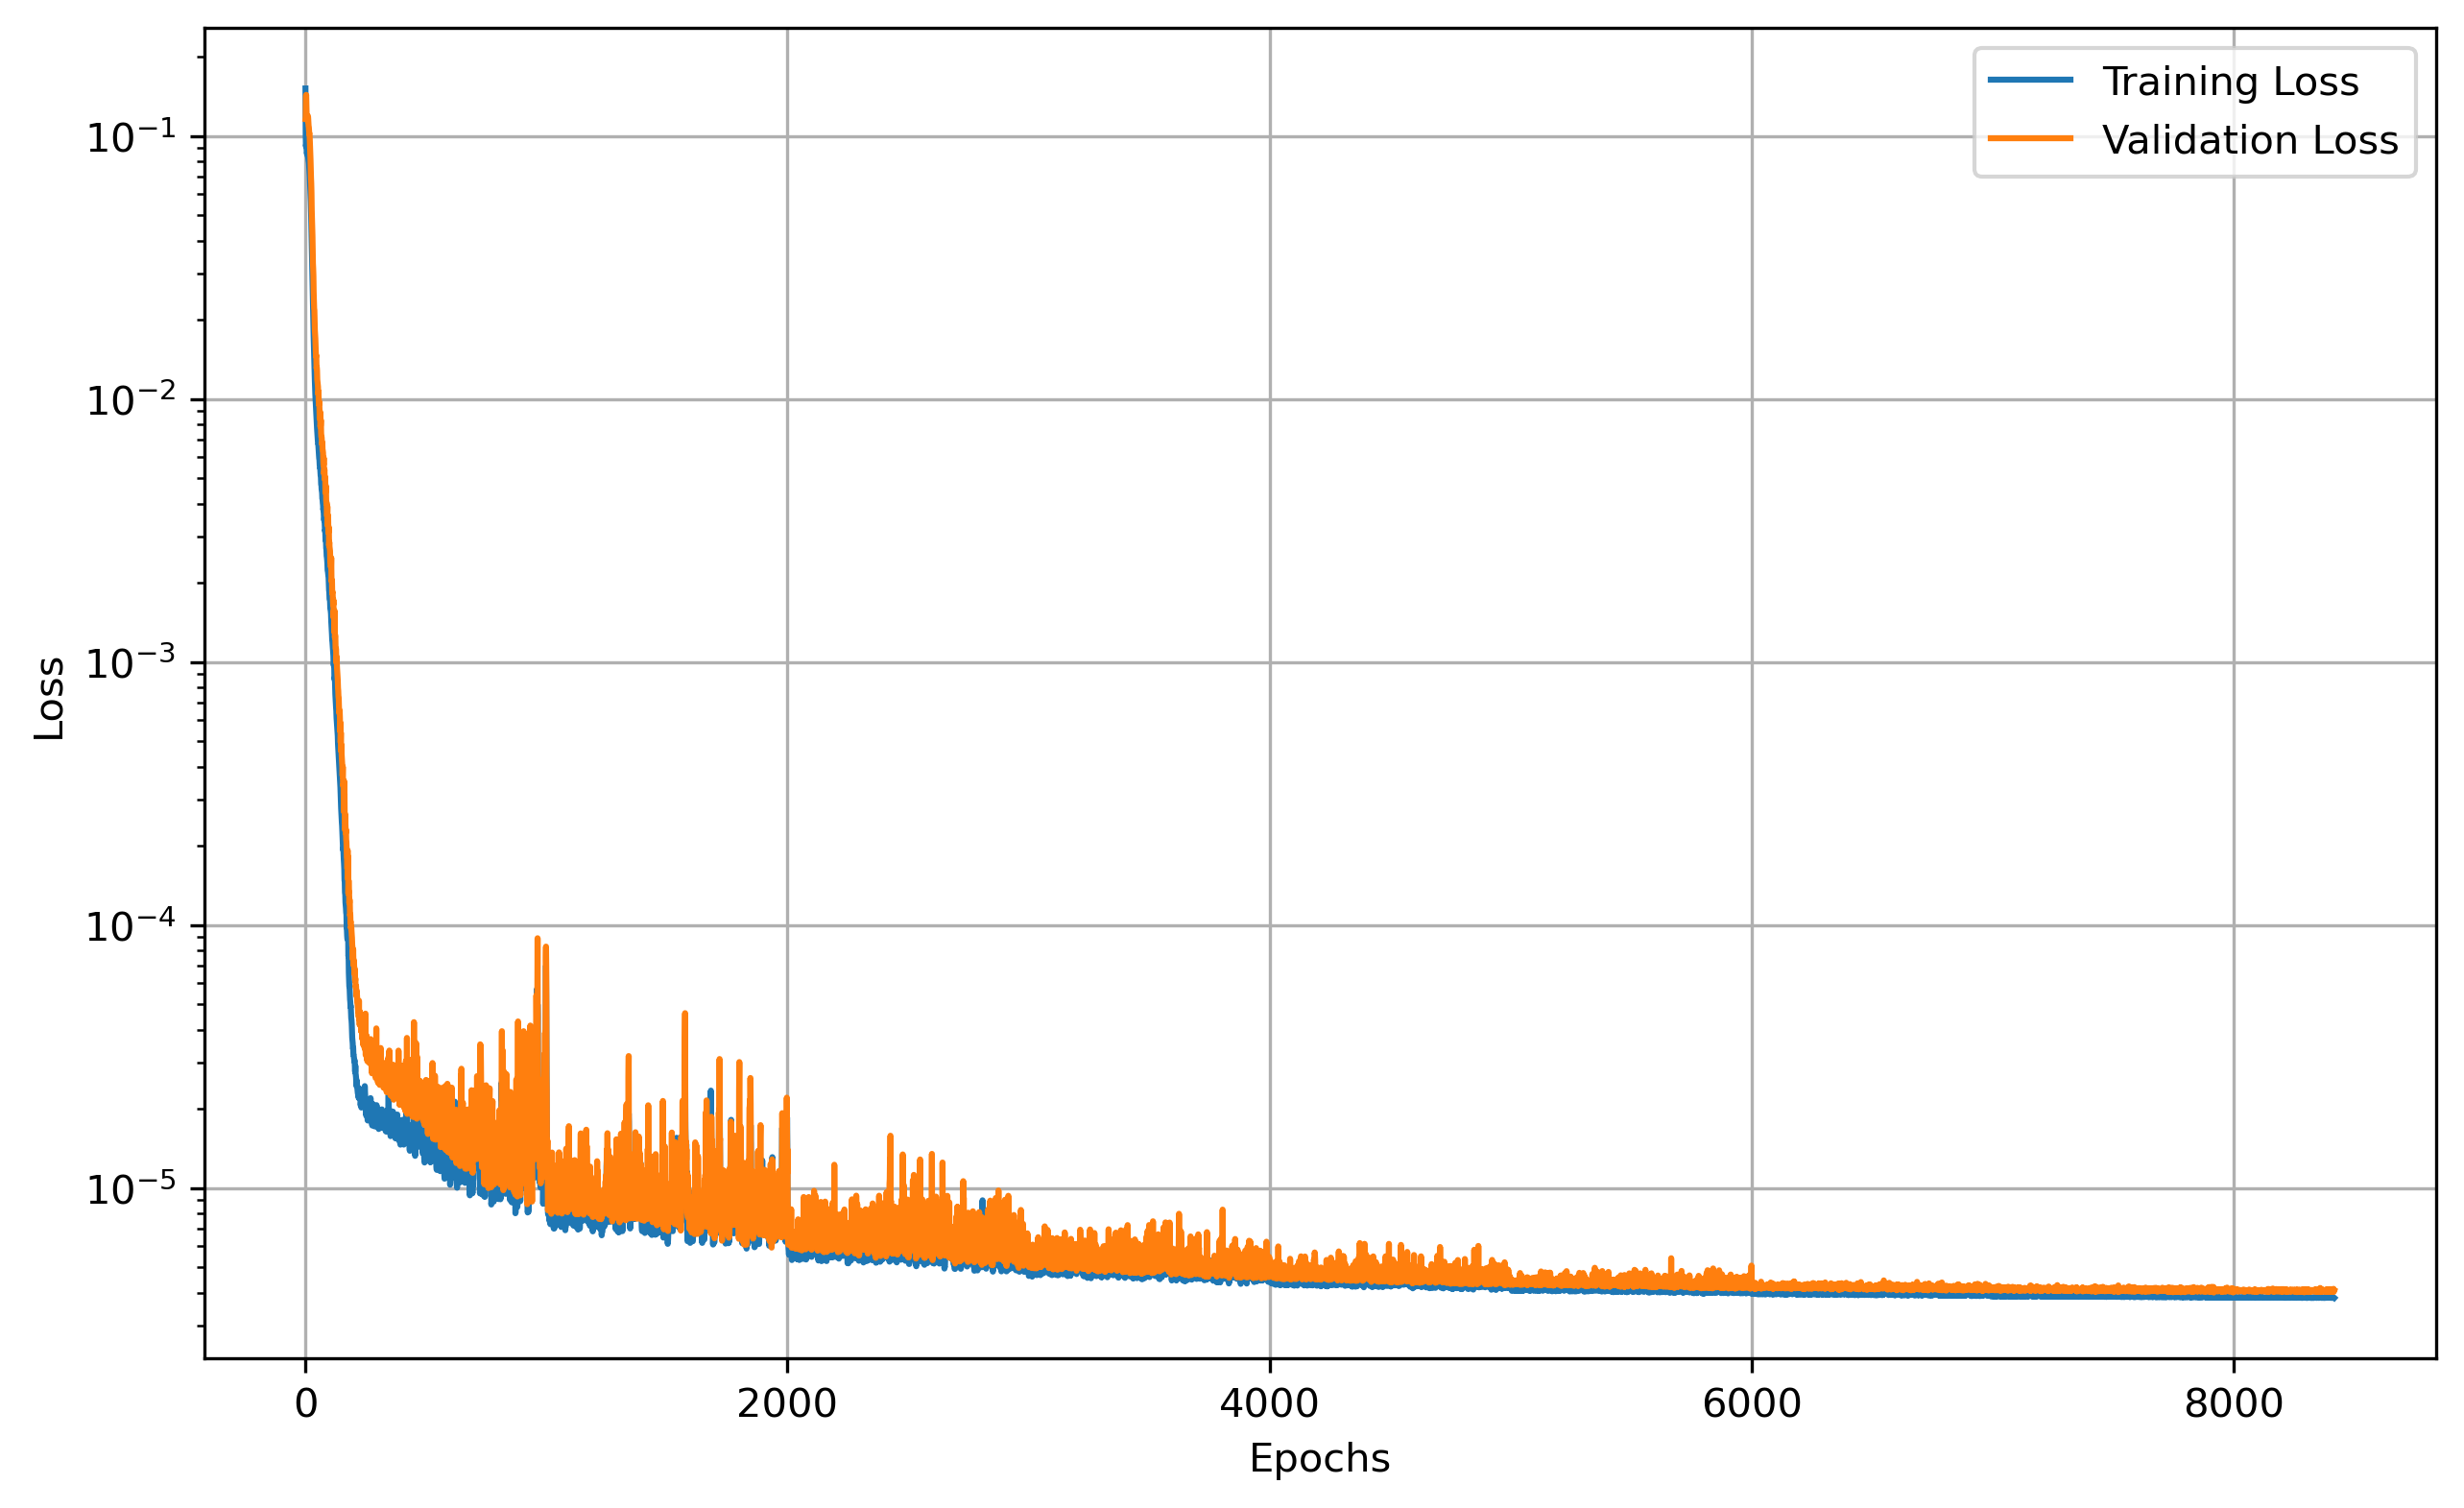

In [14]:

# Plotting training and validation loss curves
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
#plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
#plt.show()
# Saving the figure.
plt.savefig("Training and Validation Loss Curve CR interval.pdf")

In [15]:
# Evaluate the trained model
with torch.no_grad():
    outputs = model(input_tensor)
    accuracy = (1 - torch.abs(outputs[..., 0] - output_tensor).mean()).float()
    print(f'Accuracy: {accuracy.item():.6f}')

Accuracy: 0.998975


In [16]:
outputs = model(input_tensor)

In [17]:
print(output_tensor.shape)

torch.Size([401, 1])


Plotting the prediction graph

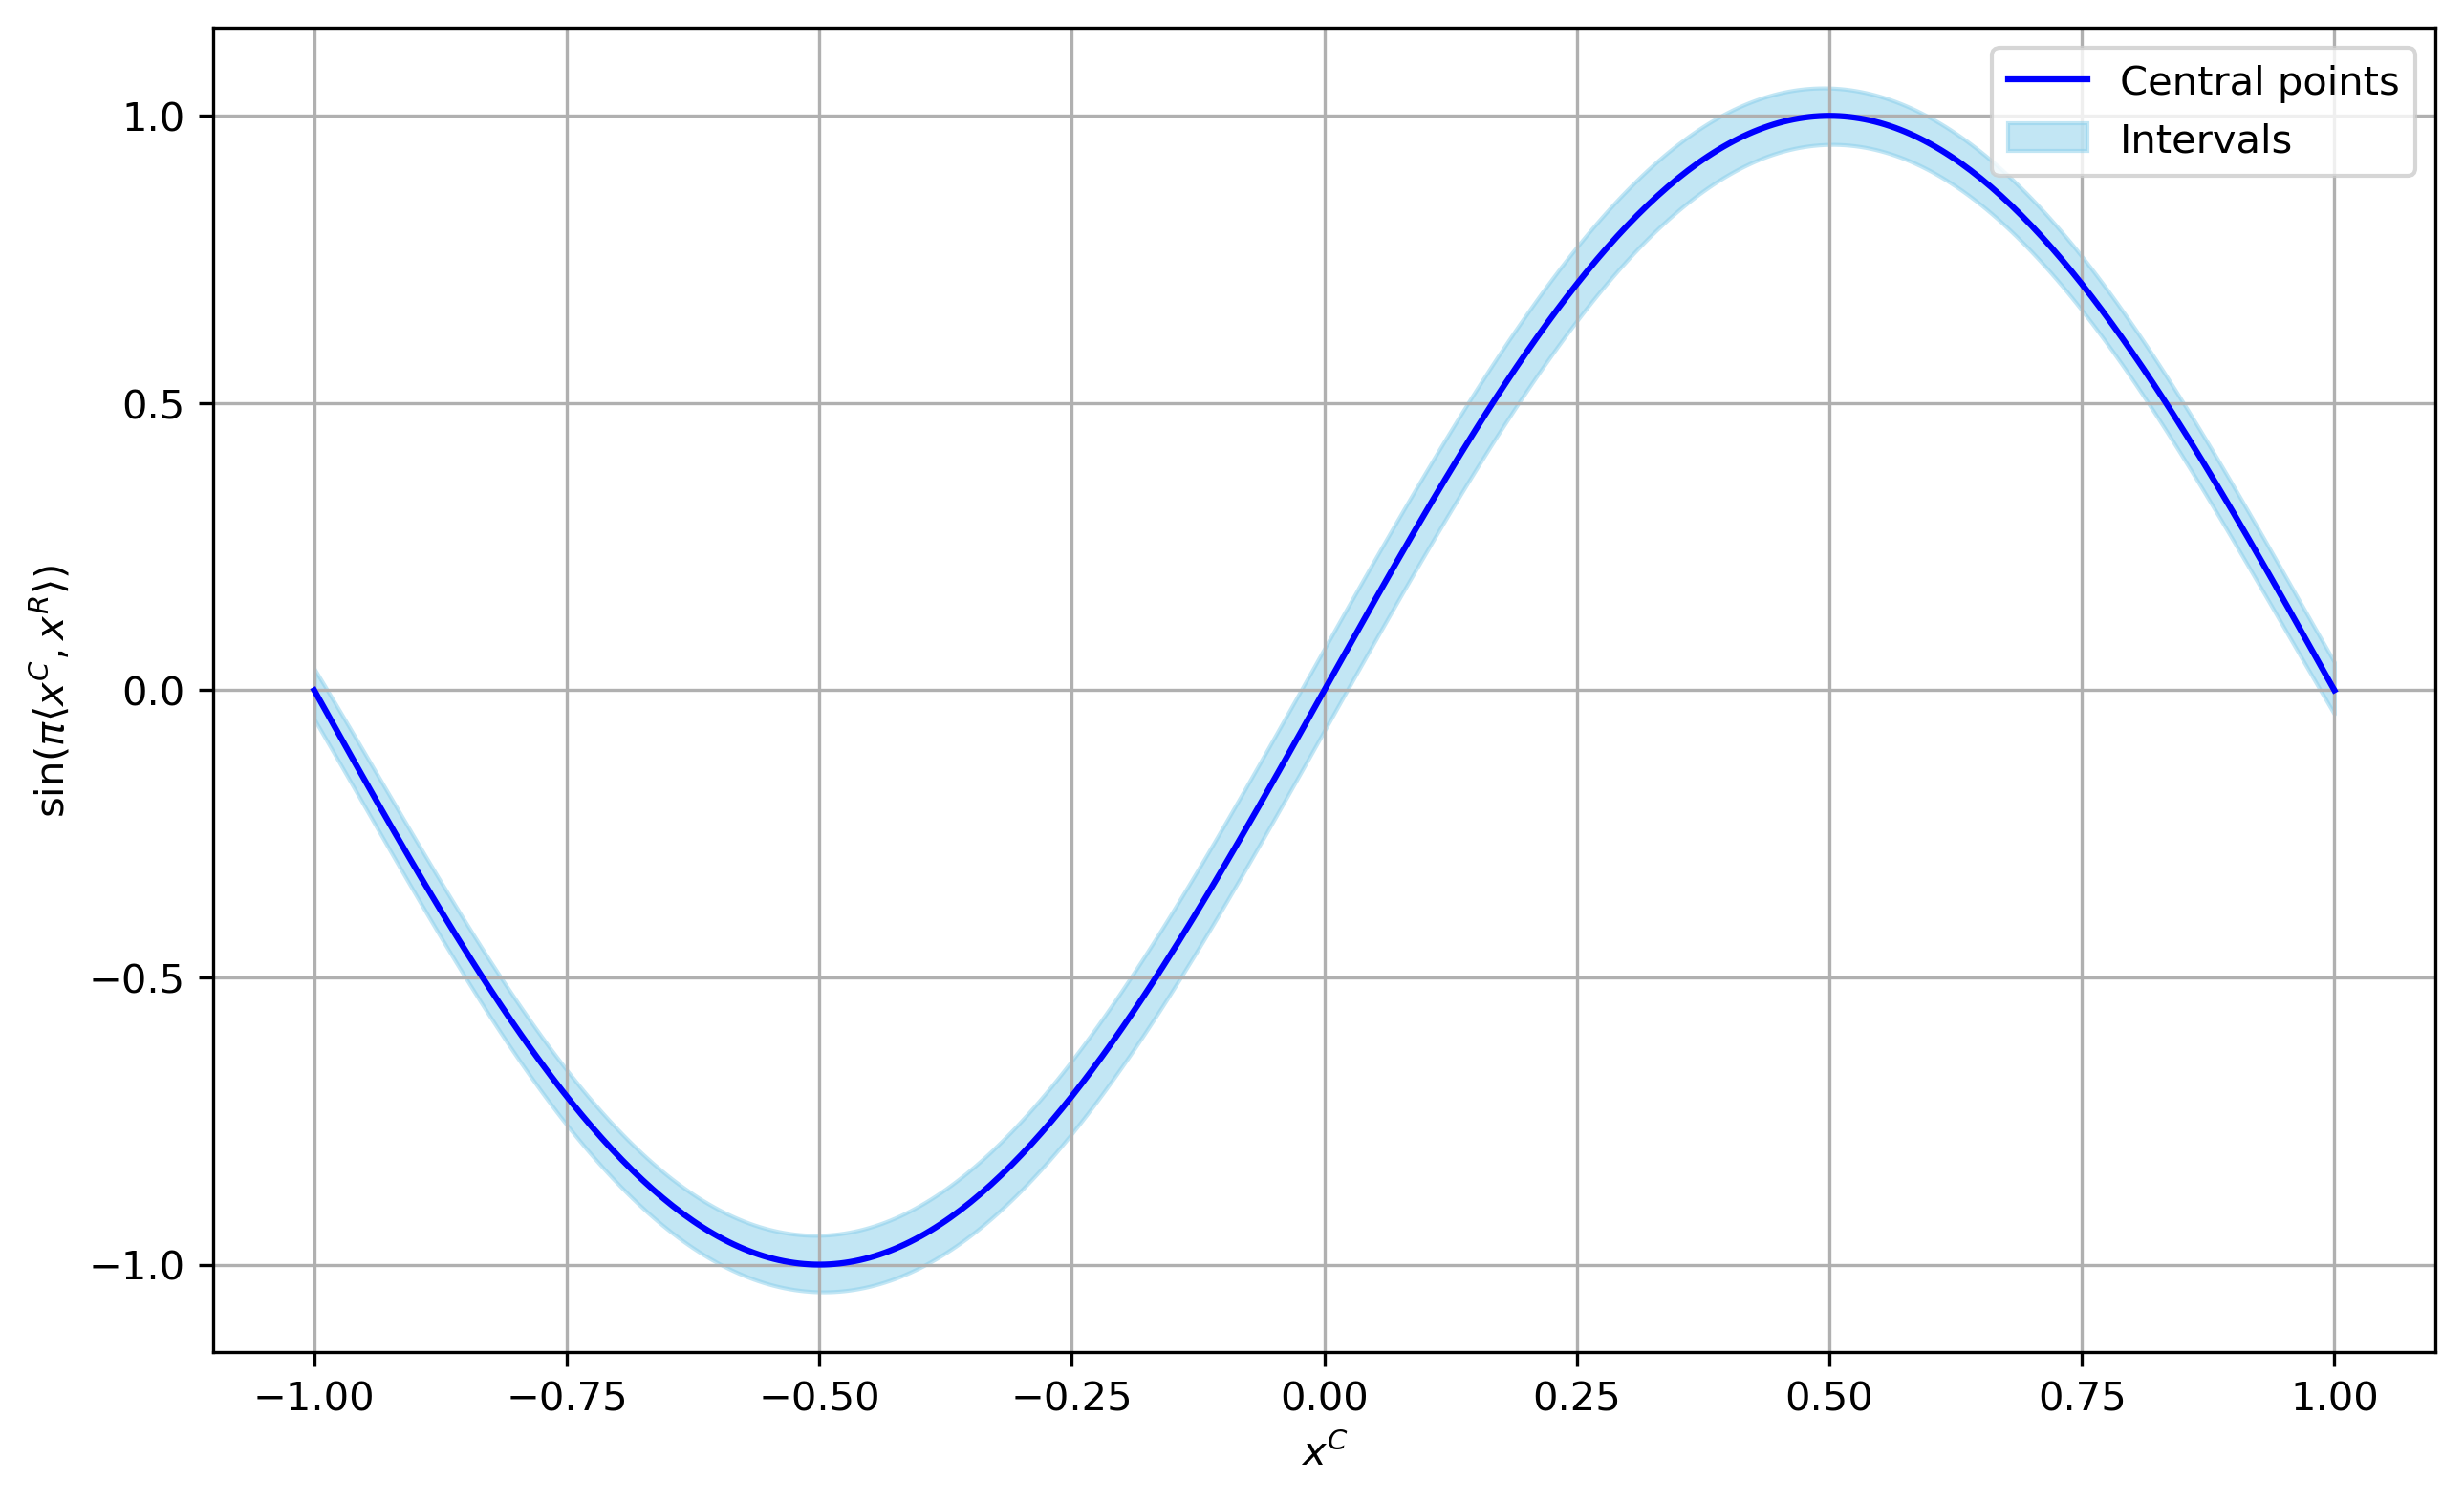

In [19]:
# Number of points
num_points = 401

# Generate 401 equally spaced points between -1 and 1
points = np.linspace(-1, 1, num_points)

# Compute sine of the intervals
sin_lower_bounds = (outputs[...,0] - outputs[...,1]).detach().numpy().flatten()
sin_upper_bounds = (outputs[...,0] + outputs[...,1]).detach().numpy().flatten()

# Plot the interval-valued function for sine
plt.figure(figsize=(10, 6), dpi = 300)
plt.plot(points, np.sin(np.pi * points), label='Central points', color='blue')
#plt.plot(points, outputs[...,0].detach().numpy(), label='predicted central points', color='red')
plt.fill_between(points, sin_lower_bounds, sin_upper_bounds, color='skyblue', alpha=0.5, label='Intervals')

# Adding labels and title
plt.xlabel(r'$x^C$')
plt.ylabel(r'$\sin(\pi \left<x^C,x^R\right>)$')
#plt.title('sin(Interval-Valued Function)')
plt.grid(True)
plt.legend()

# Display the plot
#plt.show()
plt.savefig("sin(CR Interval-Valued Function).pdf")

In [20]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

Total number of trainable parameters: 321
